In [ ]:
# My Cat & Dog Classifier Project
### By: Naraein Gowtham G A

My goal is to build a simple AI model to tell the difference between cats and dogs. I'll use transfer learning to make it easier.

In [1]:
# First, I'm importing all the tools I'll need from different libraries.
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

print("Setup Complete. TensorFlow Version:", tf.__version__)

Setup Complete. TensorFlow Version: 2.19.0


In [2]:
# This step loads the cats_vs_dogs dataset and splits it into training, validation, and testing sets.
(train_ds, validation_ds, test_ds), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

# I need to resize all images to the same size (160x160) and normalize the pixel values.
IMG_SIZE = 160
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1 # Normalize to [-1, 1]
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train_ds = train_ds.map(format_example)
validation_ds = validation_ds.map(format_example)
test_ds = test_ds.map(format_example)

# Creating batches of data so the computer doesn't run out of memory.
BATCH_SIZE = 32
train_batches = train_ds.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_batches = validation_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_batches = test_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

print("Data is loaded and prepared.")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.HCKFS4_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Data is loaded and prepared.


In [3]:
# Here's the core of the project. I'm using MobileNetV2, a model pre-trained by Google.
# I'm not including the "top" layer because I'll make my own.
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')

# Freezing the base model. I don't want to change what it has already learned.
base_model.trainable = False

# Now I'll add my own layers on top of the base model.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1) # A single output neuron for cat vs. dog

# Stacking it all together to create the final model.
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

# Compiling the model to get it ready for training.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

print("Model built successfully.")
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Model built successfully.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [4]:
# Here's the core of the project. I'm using MobileNetV2, a model pre-trained by Google.
# I'm not including the "top" layer because I'll make my own.
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')

# Freezing the base model. I don't want to change what it has already learned.
base_model.trainable = False

# Now I'll add my own layers on top of the base model.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1) # A single output neuron for cat vs. dog

# Stacking it all together to create the final model.
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

# Compiling the model to get it ready for training.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

print("Model built successfully.")
model.summary()

Model built successfully.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
# Time to train! I'll train it for 5 epochs.
history = model.fit(train_batches,
                    epochs=5,
                    validation_data=validation_batches)

Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 86s 112ms/step - accuracy: 0.7613 - loss: 0.4171 - val_accuracy: 0.9553 - val_loss: 0.1279
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.9660 - loss: 0.1042 - val_accuracy: 0.9686 - val_loss: 0.0856
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.9741 - loss: 0.0732 - val_accuracy: 0.9764 - val_loss: 0.0705
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.9773 - loss: 0.0619 - val_accuracy: 0.9785 - val_loss: 0.0628
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.9800 - loss: 0.0558 - val_accuracy: 0.9794 - val_loss: 0.0582


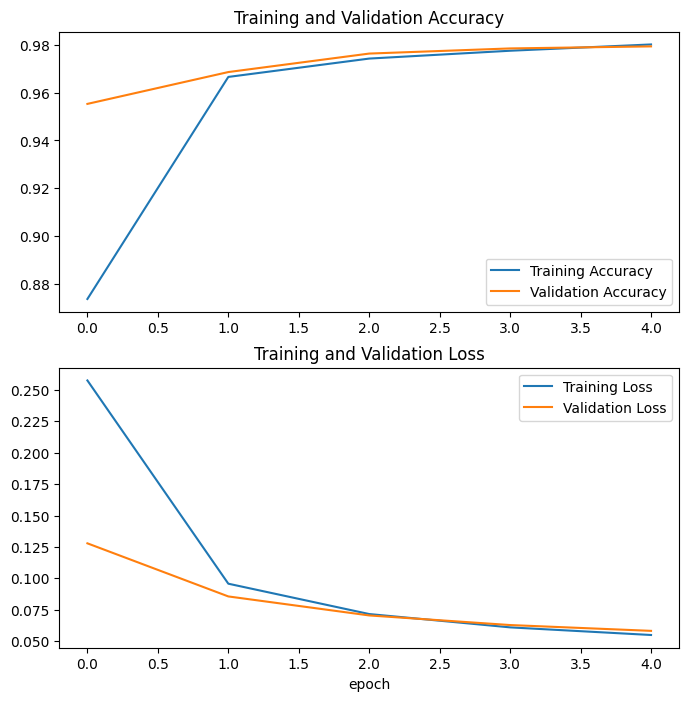

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step


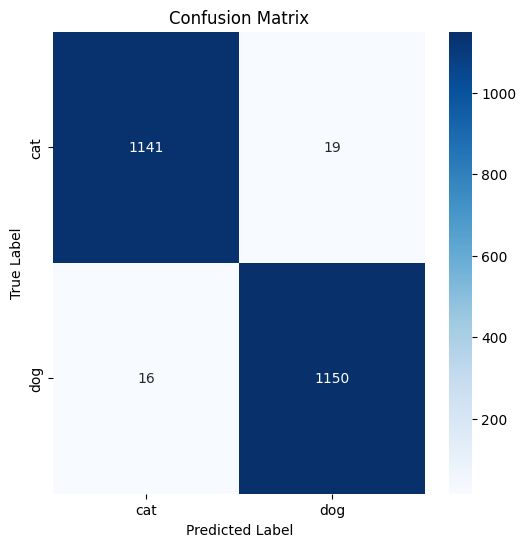

In [7]:
# Now I'll create some plots to see how the training went.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

# IMPORTANT: Saving the plot to a file
plt.savefig('training_graph.png')
plt.show()

# I'll also create a confusion matrix to see the final accuracy on the test data.
y_true = np.concatenate([y for x, y in test_batches], axis=0)
y_pred_logits = model.predict(test_batches)
y_pred = (y_pred_logits > 0).astype(int).flatten()

cm = confusion_matrix(y_true, y_pred)
class_names = ['cat', 'dog']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# IMPORTANT: Saving the confusion matrix plot
plt.savefig('confusion_matrix.png')
plt.show()